# Fortum Energy Forecasting
Creating a lightgbm model that predicts energy consumption across 112 groups from Fortum's training dataset. This is an extension of Junction 2025.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
color_pal = sns.color_palette()

import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit
import optuna
import gc
import warnings
warnings.filterwarnings('ignore')

/home/anton_s/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualization of the data set

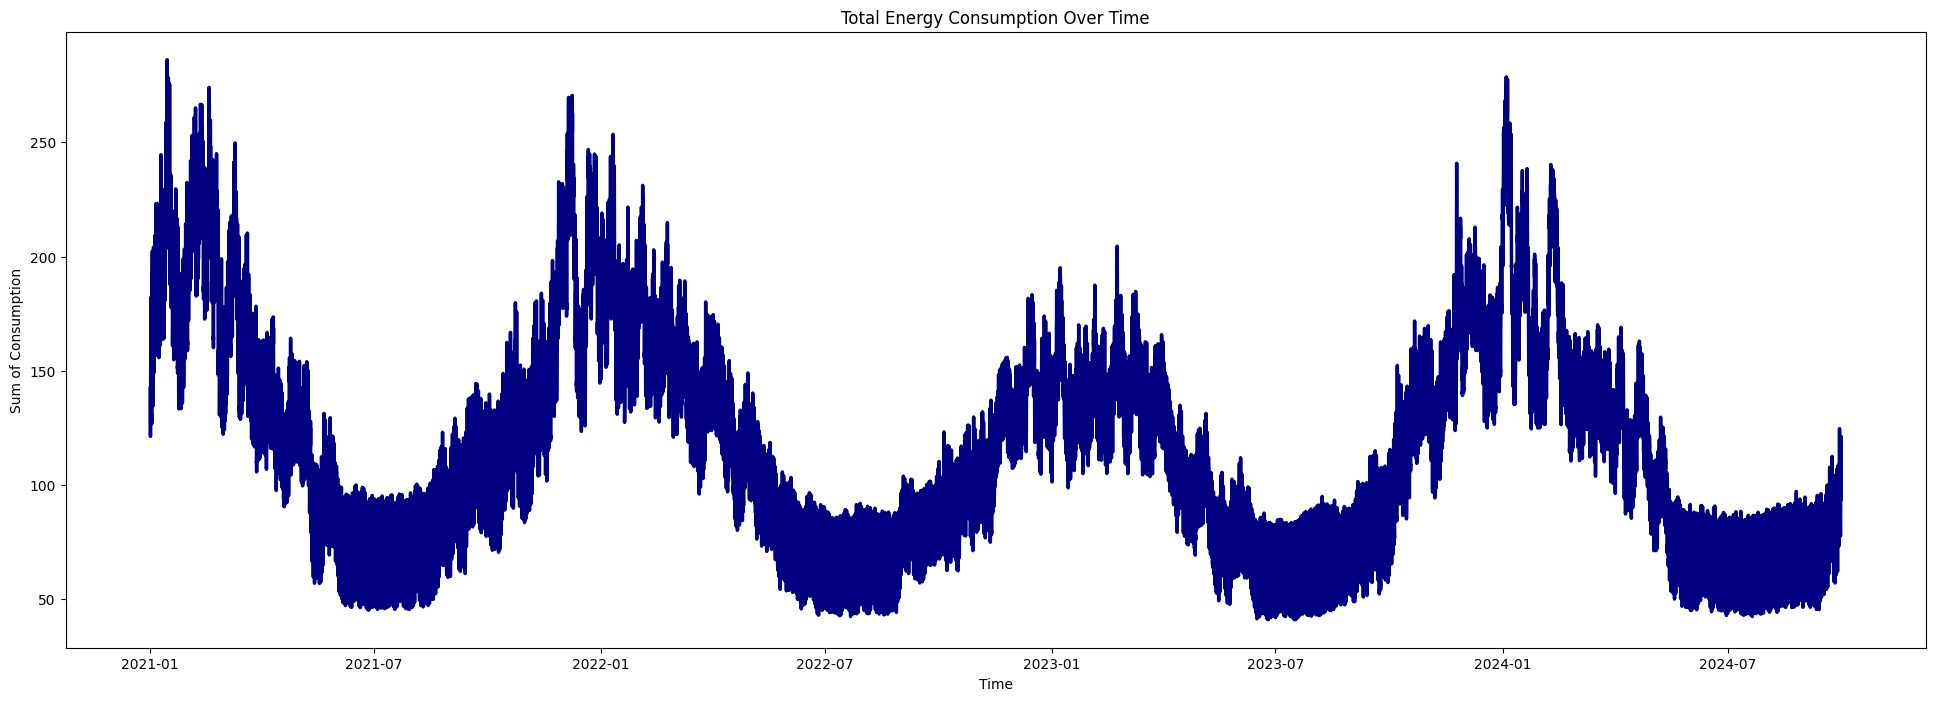

3452

In [ ]:
file_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_JUNCTION_training.xlsx"
df = pd.read_excel(file_path, sheet_name="training_consumption")

df['measured_at'] = pd.to_datetime(df['measured_at'])
df = df.set_index('measured_at')
df = df.sort_index()

total_consumption = df.sum(axis=1)
plt.figure(figsize=(24, 8))
plt.plot(total_consumption.index, total_consumption, label='Actual', color='navy', linewidth=2.5)
plt.title('Total Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Sum of Consumption')
plt.show()
del df
gc.collect()

In [2]:
file_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_JUNCTION_training.xlsx"
prices_df = pd.read_excel(file_path, sheet_name="training_prices")
df = pd.read_excel(file_path, sheet_name="training_consumption")
groups_df = pd.read_excel(file_path, sheet_name="groups")

# Convert to long format
df = df.melt(
    id_vars=['measured_at'],
    var_name='group_id',
    value_name='consumption'
)

df['measured_at'] = pd.to_datetime(df['measured_at'])
prices_df['measured_at'] = pd.to_datetime(prices_df['measured_at'])

df = pd.merge(df, prices_df, on='measured_at', how='left')

df['group_id'] = df['group_id'].astype('category')

df = df.set_index('measured_at')
df = df.sort_index()


# Checking for outliers
doesn't look like there is

<Axes: ylabel='Frequency'>

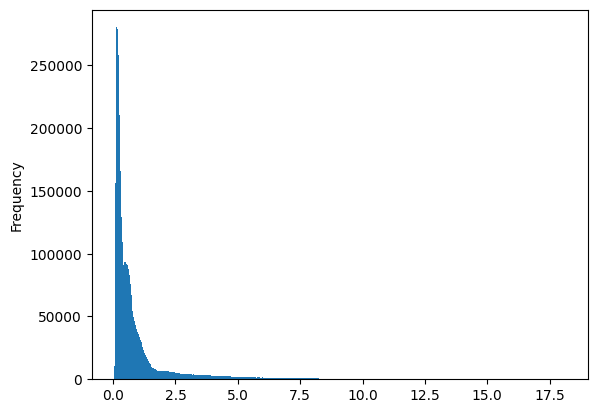

In [8]:
df['consumption'].plot(kind='hist', bins=500)

<Axes: xlabel='measured_at'>

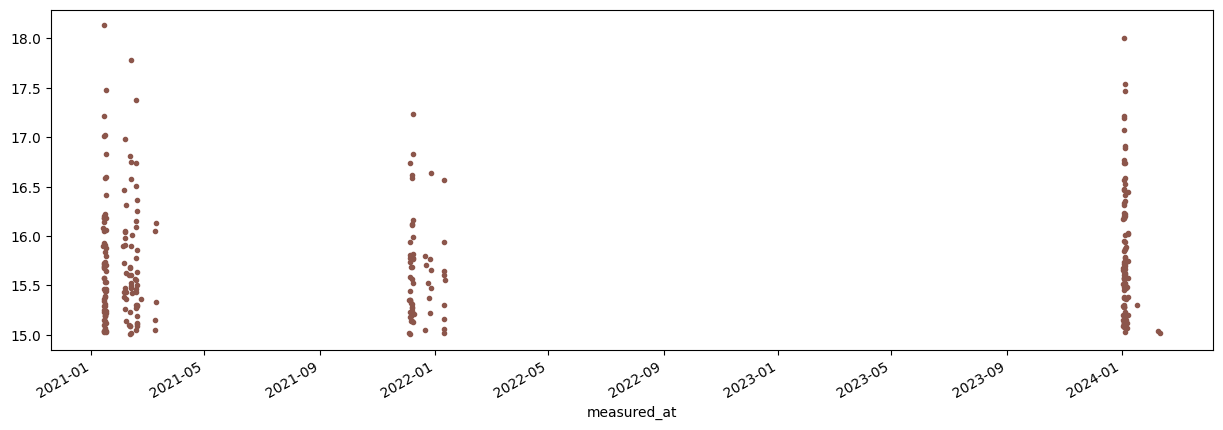

In [9]:
df.query('consumption > 15')['consumption'].plot(figsize=(15, 5),
                                                 style='.',
                                                 color=color_pal[5])

# Price plot
Price dataset unfortunately is missing 9 days of data, but this can be ignored since lightgbm handles NaNs well.

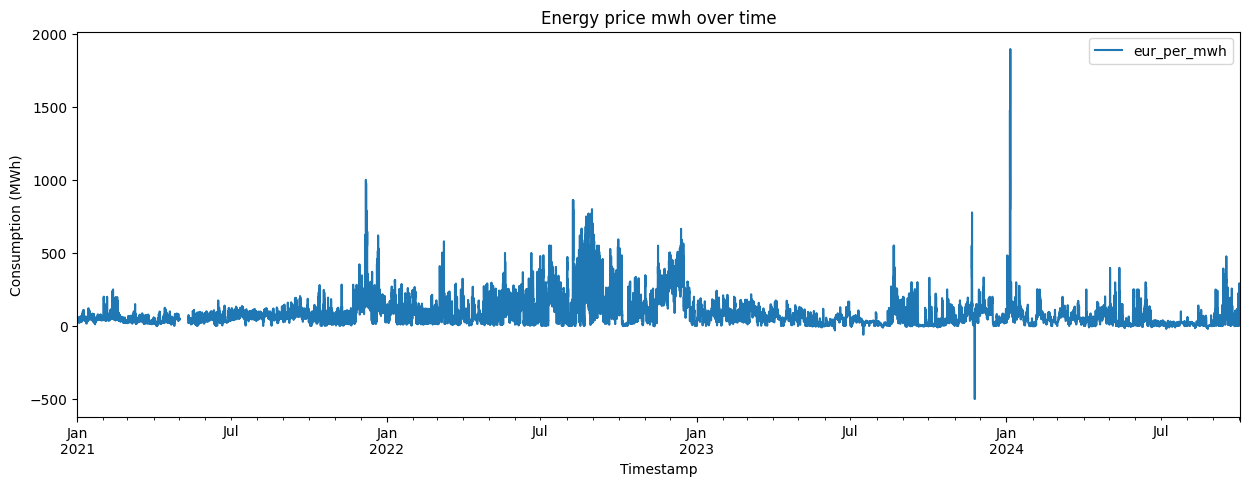

In [6]:
prices_df.plot(x='measured_at', y='eur_per_mwh', figsize=(15, 5))

plt.title('Energy price mwh over time')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (MWh)')
plt.show()

# Feature creation

# 1. Group related features
groups_df contains descriptive information of the 112 groups of which the most important features are
- Private / Enterprise customers (Household consumers / small business customers)
- 5 different electricity contract types
- level of consumption: low/medium/high


In [3]:
split_data = groups_df['group_label'].str.split('|', expand=True)
groups_df['customer_category'] = split_data[3].str.strip()

groups_df['is_enterprise'] = (groups_df['customer_category'] == 'Enterprise').astype(int)
groups_df['is_private'] = (groups_df['customer_category'] == 'Private').astype(int)

contract_map = {
    'Spot Price': 1,
    'Fixed Price': 2,
    'Variable Price': 3,
    'Flat/Hybrid': 4,
    'Portfolio': 5
}

volume_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}
groups_df['contract_type'] = split_data[4].str.strip()
groups_df['contract_type_int'] = groups_df['contract_type'].map(contract_map)

groups_df['cons_level_str'] = split_data[5].str.strip()
groups_df['cons_level_int'] = groups_df['cons_level_str'].map(volume_map)

In [4]:
def add_group_features(df, groups_df):
    df = df.copy()
    groups_df = groups_df.copy()

    index_name = df.index.name
    was_index = False
    
    if index_name == 'measured_at':
        df = df.reset_index()
        was_index = True
    elif 'measured_at' not in df.columns:
        df = df.reset_index()
        if 'measured_at' not in df.columns:
            df = df.rename(columns={'index': 'measured_at'})
        was_index = True

    features_to_add = ['is_private', 'is_enterprise', 'contract_type_int', 'cons_level_int']
    
    cols_to_drop = [col for col in features_to_add if col in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    df['group_id_temp'] = df['group_id'].astype(str)
    groups_df['group_id_temp'] = groups_df['group_id'].astype(str)

    cols_to_merge = ['group_id_temp'] + features_to_add

    df = pd.merge(
        df,
        groups_df[cols_to_merge],
        on='group_id_temp',
        how='left'
    )

    df = df.drop(columns=['group_id_temp'])
    
    if was_index:
        df = df.set_index('measured_at')
        df = df.sort_index()

    df['group_id'] = df['group_id'].astype('category')

    return df

df = add_group_features(df, groups_df)

# 2. Energy price feature
Energy price is featured as a 24 hour lag feature. This is because in the true 48h forecast, energy price is only available 24 hours into the future.

In [5]:
df['price_24h_lag'] = df['eur_per_mwh'].shift(24)
df.drop(['eur_per_mwh'], axis=1, inplace=True)

# 3. time series features


In [6]:
def create_ts_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['season'] = ((df['month']%12 + 3)//3)
    return df

df = create_ts_features(df)

# 4. Lag features

Since forecasting window is 48 hours, the lags must be minimum 48 hours. Otherwise there would be data leakage in the training and validation of the model


In [7]:
def add_lag(df):
    df = df.copy()
    # Create lags per group
    for group in df['group_id'].unique():
        group_data = df[df['group_id'] == group].sort_index()
        target_map = group_data['consumption'].to_dict()
        df.loc[df['group_id'] == group, '2 day lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('2 days')).map(target_map)
        df.loc[df['group_id'] == group, '3 day lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('3 days')).map(target_map)
        df.loc[df['group_id'] == group, '1 week lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('7 days')).map(target_map)
        df.loc[df['group_id'] == group, '1y lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('364 days')).map(target_map)
    return df

In [8]:
df = add_lag(df)
df = df.sort_index() 

# 5. Statistical features

stats for the period between 96 hours ago and 48 hours ago. It's concluded that max_rolling is the most important feature

In [9]:
def add_stats(df):
    df = df.copy()
    safe_series = df.groupby('group_id')['consumption'].shift(48)
    
    #df['std_rolling'] = safe_series.rolling(window=48).std()
    #df['mean_rolling'] = safe_series.rolling(window=48).mean()
    df['max_rolling'] = safe_series.rolling(window=48).max()
    #df['min_rolling'] = safe_series.rolling(window=48).min()
    return df

In [10]:
df = add_stats(df)
df = df.sort_index() 

# 6. Weather features
Key weather features are:

* Temperature
* Wind
* Humidity
* Rain



In [11]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time

# Tallennetaan säädata csv-tiedostoon

locations = {
    "Etelä-Savo": {"city": "Savonlinna", "lat": 61.8699, "lon": 28.8800},
    "Pohjois-Savo": {"city": "Kuopio", "lat": 62.8924, "lon": 27.6770},
    "Rovaniemi": {"city": "Rovaniemi", "lat": 66.5039, "lon": 25.7294},
    "Lappi": {"city": "Kemi", "lat": 65.7328, "lon": 24.5641},
    "Pohjois-Pohjanmaa": {"city": "Kajaani", "lat": 64.2238, "lon": 27.7278},
    "Kanta-Häme_others": {"city": "Forssa", "lat": 60.8146, "lon": 23.6151},
    "Kanta-Häme": {"city": "Hämeenlinna", "lat": 60.9959, "lon": 24.4643},
    "Päijät_Häme_others": {"city": "Heinola", "lat": 61.2056, "lon": 26.0381},
    "Uusimaa_others": {"city": "Hyvinkää", "lat": 60.6305, "lon": 24.8597},
    "Varsinais-Suomi_others": {"city": "Salo", "lat": 60.3867, "lon": 23.1250},
    "Pirkanmaa_others": {"city": "Nokia", "lat": 61.4779, "lon": 23.5098},
    "Pohjanmaa": {"city": "Seinäjoki", "lat": 62.7903, "lon": 22.8403},
    "Etelä-Pohjanmaa": {"city": "Seinäjoki", "lat": 62.7903, "lon": 22.8403},
    "Keski-Suomi_others": {"city": "Jämsä", "lat": 61.8643, "lon": 25.1900},
    "Joensuu": {"city": "Joensuu", "lat": 62.6010, "lon": 29.7636},
    "Helsinki": {"city": "Helsinki", "lat": 60.1695, "lon": 24.9354},
    "Tampere": {"city": "Tampere", "lat": 61.4978, "lon": 23.7610},
    "Oulu": {"city": "Oulu", "lat": 65.0124, "lon": 25.4682},
    "Turku": {"city": "Turku", "lat": 60.4515, "lon": 22.2666},
    "Lappeenranta": {"city": "Lappeenranta", "lat": 61.0587, "lon": 28.1887},
    "Espoo": {"city": "Espoo", "lat": 60.2055, "lon": 24.6559},
    "Lahti": {"city": "Lahti", "lat": 60.9827, "lon": 25.6612},
    "Vantaa": {"city": "Vantaa", "lat": 60.2941, "lon": 25.0409},
    "Pori": {"city": "Pori", "lat": 61.4851, "lon": 21.7974},
    "Jyväskylä": {"city": "Jyväskylä", "lat": 62.2415, "lon": 25.7209}
}
# Setup
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
url = "https://archive-api.open-meteo.com/v1/archive"

all_data = []

print(f"Aloitetaan haku {len(locations)} kaupungille...")

for i, (group_name, info) in enumerate(locations.items(), 1):
    
    print(f"[{i}/{len(locations)}] Haetaan: {group_name} ({info['city']})...", end=" ")
    
    params = {
        "latitude": info["lat"],
        "longitude": info["lon"],
        "start_date": "2021-01-01",
        "end_date": "2025-09-30",
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "wind_speed_10m"],
        "timezone": "Europe/Helsinki"
    }
    
    try:
        # Tehdään haku
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]
        
        # Käsitellään data
        hourly = response.Hourly()
        hourly_data = {
            "date": pd.date_range(
                start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
                end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
                freq = pd.Timedelta(seconds = hourly.Interval()),
                inclusive = "left"
            )
        }
        
        hourly_data["Ryhmä"] = group_name
        hourly_data["Kaupunki"] = info["city"]
        hourly_data["Lämpötila (°C)"] = hourly.Variables(0).ValuesAsNumpy()
        hourly_data["Kosteus (%)"] = hourly.Variables(1).ValuesAsNumpy()
        hourly_data["Sade (mm)"] = hourly.Variables(2).ValuesAsNumpy()
        hourly_data["Tuuli (m/s)"] = hourly.Variables(3).ValuesAsNumpy()

        df_loc = pd.DataFrame(data = hourly_data)
        all_data.append(df_loc)
        
        print("OK.") # Kerrotaan käyttäjälle että onnistui

    except Exception as e:
        print(f"\n!!! VIRHE kohdassa {group_name}: {e}")
        # 'continue' varmistaa että silmukka ei katkea, vaan yrittää seuraavaa
        continue 
    
    time.sleep(5) 

if all_data:
    print("\nYhdistetään dataa...")
    final_df = pd.concat(all_data)
    final_df.to_csv("saa_data_FINAL.csv", index=False)
    print(f"Valmis! Tallennettu {len(final_df)} riviä tiedostoon saa_data_FINAL.csv")
else:
    print("Mitään dataa ei saatu haettua.")



Aloitetaan haku 25 kaupungille...
[1/25] Haetaan: Etelä-Savo (Savonlinna)... OK.
[2/25] Haetaan: Pohjois-Savo (Kuopio)... OK.
[3/25] Haetaan: Rovaniemi (Rovaniemi)... OK.
[4/25] Haetaan: Lappi (Kemi)... OK.
[5/25] Haetaan: Pohjois-Pohjanmaa (Kajaani)... OK.
[6/25] Haetaan: Kanta-Häme_others (Forssa)... OK.
[7/25] Haetaan: Kanta-Häme (Hämeenlinna)... OK.
[8/25] Haetaan: Päijät_Häme_others (Heinola)... OK.
[9/25] Haetaan: Uusimaa_others (Hyvinkää)... OK.
[10/25] Haetaan: Varsinais-Suomi_others (Salo)... OK.
[11/25] Haetaan: Pirkanmaa_others (Nokia)... OK.
[12/25] Haetaan: Pohjanmaa (Seinäjoki)... OK.
[13/25] Haetaan: Etelä-Pohjanmaa (Seinäjoki)... OK.
[14/25] Haetaan: Keski-Suomi_others (Jämsä)... OK.
[15/25] Haetaan: Joensuu (Joensuu)... OK.
[16/25] Haetaan: Helsinki (Helsinki)... OK.
[17/25] Haetaan: Tampere (Tampere)... OK.
[18/25] Haetaan: Oulu (Oulu)... OK.
[19/25] Haetaan: Turku (Turku)... OK.
[20/25] Haetaan: Lappeenranta (Lappeenranta)... OK.
[21/25] Haetaan: Espoo (Espoo)... OK.

In [12]:

# Sanakirja: "ID_numero": "Säädatan_kaupunki"
# Tuntemattomat otetaan vain suurimman kaupungin mukaan.
id_to_city_map = {
    "28": "Savonlinna",  # Etelä-Savo
    "29": "Savonlinna",
    "30": "Savonlinna",
    "36": "Joensuu",
    "37": "Joensuu",
    "38": "Joensuu",
    "39": "Joensuu",
    "40": "Joensuu",
    "41": "Joensuu",
    "42": "Joensuu",
    "43": "Joensuu",
    "73": "Joensuu",
    "74": "Joensuu",
    "76": "Joensuu",
    "116": "Kuopio",
    "149": "Kemi",      # Lappi
    "150": "Kemi",
    "151": "Kemi",
    "152": "Kemi",
    "157": "Rovaniemi",
    "196": "Oulu",
    "197": "Oulu",
    "198": "Oulu",
    "199": "Oulu",
    "200": "Oulu",
    "201": "Oulu",
    "213": "Oulu",
    "222": "Kajaani",   # Pohjois-Pohjanmaa
    "225": "Kajaani",
    "231": "Kajaani",
    "233": "Kajaani",
    "234": "Kajaani",
    "235": "Kajaani",
    "237": "Kajaani",
    "238": "Kajaani",
    "270": "Lappeenranta",
    "271": "Lappeenranta",
    "295": "Hämeenlinna",
    "298": "Hämeenlinna",
    "301": "Hämeenlinna",
    "302": "Hämeenlinna",
    "303": "Hämeenlinna",
    "304": "Forssa",      # Kanta-Häme_others
    "305": "Hämeenlinna",
    "307": "Hämeenlinna",
    "308": "Hämeenlinna",
    "346": "Lahti",
    "347": "Lahti",
    "348": "Lahti",
    "378": "Lahti",
    "380": "Heinola",     # Päijät_Häme_others
    "385": "Espoo",
    "387": "Espoo",
    "390": "Espoo",
    "391": "Espoo",
    "393": "Espoo",
    "394": "Espoo",
    "395": "Espoo",
    "396": "Espoo",
    "397": "Espoo",
    "398": "Espoo",
    "399": "Espoo",
    "400": "Espoo",
    "401": "Espoo",
    "402": "Espoo",
    "403": "Espoo",
    "404": "Espoo",
    "405": "Espoo",
    "447": "Hyvinkää",    # Uusimaa_others
    "450": "Hyvinkää",
    "459": "Vantaa",
    "460": "Vantaa",
    "466": "Vantaa",
    "468": "Pori",
    "469": "Pori",
    "538": "Salo",  
    "541": "Salo",  
    "542": "Salo", 
    "561": "Seinäjoki",
    "570": "Seinäjoki",
    "573": "Seinäjoki",
    "577": "Seinäjoki",
    "580": "Seinäjoki",
    "581": "Seinäjoki",
    "582": "Seinäjoki",
    "583": "Seinäjoki",
    "585": "Seinäjoki",
    "586": "Seinäjoki",
    "622": "Jyväskylä",
    "623": "Jyväskylä",
    "624": "Jyväskylä",
    "625": "Jyväskylä",
    "626": "Jyväskylä",
    "657": "Jyväskylä",
    "658": "Jämsä",       # Keski-Suomi_others
    "659": "Jämsä",
    "682": "Nokia",       # Pirkanmaa_others
    "691": "Nokia",
    "692": "Nokia",
    "693": "Nokia",
    "694": "Nokia",
    "695": "Nokia",
    "697": "Nokia",
    "698": "Nokia",
    "705": "Tampere",
    "706": "Tampere",
    "707": "Tampere",
    "708": "Tampere",
    "709": "Tampere",
    "738": "Seinäjoki",
    "740": "Seinäjoki",
    "741": "Seinäjoki"
}

In [13]:

weather_df = pd.read_csv("saa_data_FINAL.csv")

df = df.reset_index()
df['group_id_str'] = df['group_id'].astype(str)
df['Kaupunki'] = df['group_id_str'].map(id_to_city_map)

weather_df = weather_df.rename(columns={'date': 'measured_at'})
df['measured_at'] = pd.to_datetime(df['measured_at'], utc=True)
weather_df['measured_at'] = pd.to_datetime(weather_df['measured_at'], utc=True)

weather_cols = ['measured_at', 'Kaupunki', 'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)']
weather_df_clean = weather_df[weather_cols].copy()

weather_df_clean = weather_df_clean.drop_duplicates(subset=['measured_at', 'Kaupunki'], keep='first')


df_final = pd.merge(
    df,
    weather_df_clean,
    on=['measured_at', 'Kaupunki'],
    how='left'
)

df_final['group_id'] = df_final['group_id'].astype('category')


df_final = df_final.sort_values(by=['measured_at', 'group_id'])


df_final = df_final.set_index('measured_at')


In [14]:
#Delete useless dataframes
del weather_df_clean, weather_df
gc.collect() # Pakota muistin vapautus

0

In [15]:
turhat_sarakkeet = ['index', 'level_0', 'Kaupunki', 'group_id_str']
df_final = df_final.drop(columns=turhat_sarakkeet, errors='ignore')

In [16]:
df = df_final
del df_final
gc.collect()

0

# 7. Sun elevation feature
- Angle of sun and boolean value of wether the sun is up or not
- Divide it to three areas

In [17]:
from astral import LocationInfo
from astral.sun import elevation

zone_coords = {
    'South':  (60.20, 24.65), # Espoo
    'Middle': (62.24, 25.74), # Jyväskylä
    'North':  (65.01, 25.46)  # Oulu
}

city_to_zone = {
    # Etelä (South) - Espoon koordinaatit
    'Espoo': 'South', 'Vantaa': 'South', 'Helsinki': 'South', 'Lahti': 'South', 
    'Heinola': 'South', 'Hämeenlinna': 'South', 'Forssa': 'South', 
    'Hyvinkää': 'South', 'Salo': 'South', 'Pori': 'South', 'Lappeenranta': 'South',
    
    # Keski (Middle) - Jyväskylän koordinaatit
    'Tampere': 'Middle', 'Nokia': 'Middle', 'Jyväskylä': 'Middle', 'Jämsä': 'Middle', 
    'Seinäjoki': 'Middle', 'Kuopio': 'Middle', 'Joensuu': 'Middle', 'Savonlinna': 'Middle',
    
    # Pohjoinen (North) - Oulun koordinaatit
    'Oulu': 'North', 'Kajaani': 'North', 'Kemi': 'North', 'Rovaniemi': 'North'
}
id_to_coords = {}

for group_id_str, city_name in id_to_city_map.items():
    zone = city_to_zone.get(city_name, 'South') # Oletus South jos kaupunkia ei löydy
    coords = zone_coords.get(zone)
    id_to_coords[group_id_str] = coords

In [18]:
from astral import Observer
from astral.sun import elevation

df.index = pd.to_datetime(df.index)

df['measured_at_temp'] = df.index

south_coords = zone_coords['South'] 

df['temp_coords'] = df['group_id'].astype(str).map(id_to_coords)

df['temp_coords'] = df['temp_coords'].apply(lambda x: x if isinstance(x, tuple) else south_coords)

coords_df = pd.DataFrame(
    df['temp_coords'].tolist(), 
    index=df.index,
    columns=['latitude', 'longitude']
)

df['latitude'] = coords_df['latitude']
df['longitude'] = coords_df['longitude']
df.drop(columns=['temp_coords'], inplace=True)

print("Lasketaan auringon asentoa...")

unique_params = df[['measured_at_temp', 'latitude', 'longitude']].drop_duplicates().copy()

def calculate_sun_fast(row):
    obs = Observer(latitude=row['latitude'], longitude=row['longitude'])
    try:
        return elevation(obs, row['measured_at_temp'])
    except:
        return 0.0

unique_params['sun_elevation'] = unique_params.apply(calculate_sun_fast, axis=1)

df = df.merge(
    unique_params[['measured_at_temp', 'latitude', 'longitude', 'sun_elevation']], 
    on=['measured_at_temp', 'latitude', 'longitude'], 
    how='left'
)

if 'measured_at_temp' in df.columns:
    df.index = df['measured_at_temp']

df['is_sun_up'] = (df['sun_elevation'] > 0).astype(int)

df.drop(columns=['latitude', 'longitude', 'measured_at_temp'], inplace=True)

print("Valmis! Tulokset:")
print(df[['group_id', 'sun_elevation', 'is_sun_up']].head())

Lasketaan auringon asentoa...
Valmis! Tulokset:
                          group_id  sun_elevation  is_sun_up
measured_at_temp                                            
2021-01-01 00:00:00+00:00       28     -47.277134          0
2021-01-01 00:00:00+00:00       29     -47.277134          0
2021-01-01 00:00:00+00:00       30     -47.277134          0
2021-01-01 00:00:00+00:00       36     -47.277134          0
2021-01-01 00:00:00+00:00       37     -47.277134          0


# Correlation matrix 

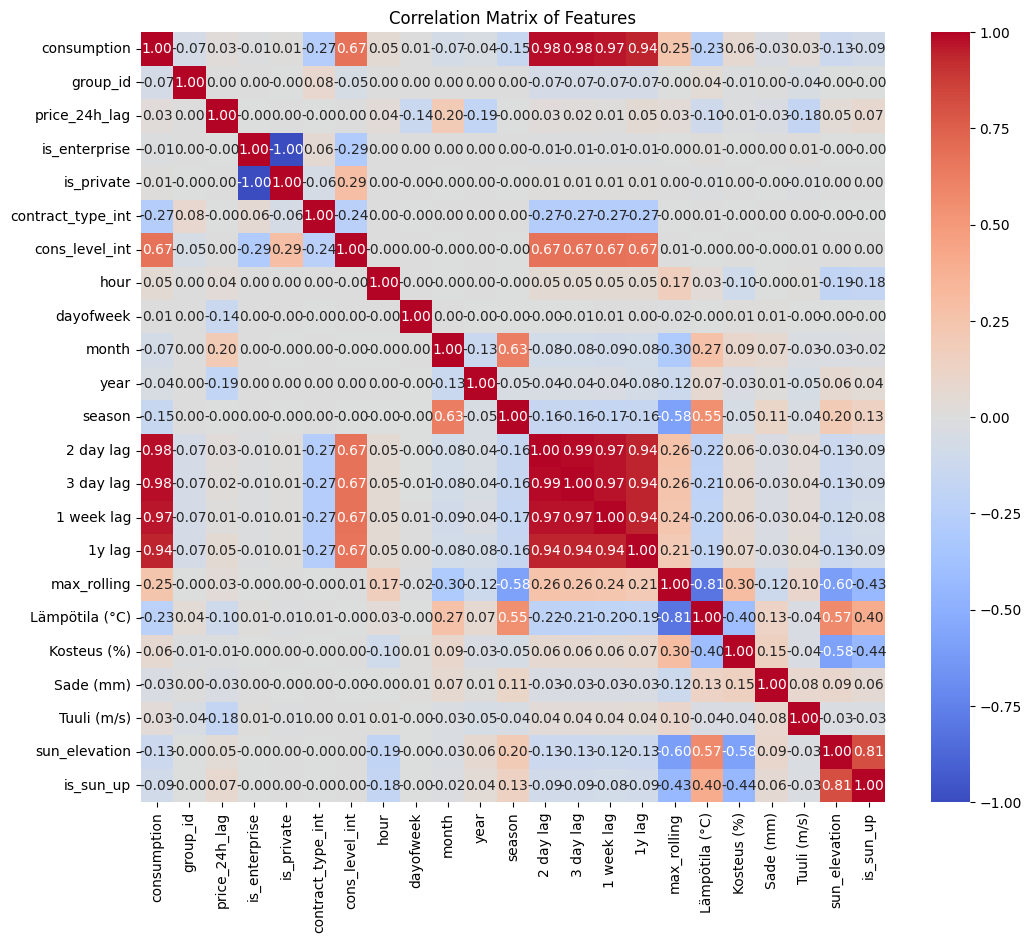

In [ ]:
features = ['consumption', 'group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]

corr_matrix = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,      
            fmt=".2f",     
            cmap='coolwarm',  
            vmin=-1, vmax=1)  
plt.title('Correlation Matrix of Features')
plt.show()



# Model Creation
Hyperparameter tuning is done using Optuna, which is based on Bayesian optimization.

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback

df.dropna()
features = ['group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]

X = df[features]
y = df['consumption']


# 8-fold split
tscv = TimeSeriesSplit(n_splits=8, test_size=24*30*112, gap=24)

def objective(trial):
    # Hyper-parameters
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 10000, 
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    fold_scores = []
    
    # Define the pruning callback
    pruning_callback = LightGBMPruningCallback(trial, "mape")

    for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

        
        callbacks_list = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        
       
        if i == 0:
            callbacks_list.append(pruning_callback)

        model = lgb.LGBMRegressor(**params)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='mape',
            callbacks=callbacks_list  
        )
        
        best_score = model.best_score_['valid_0']['mape']
        fold_scores.append(best_score)

    return np.mean(fold_scores)

# --- RUN STUDY ---
print("🔍 Starting Optuna Optimization (8-Fold TimeSeriesSplit)...")

sampler = TPESampler(seed=42)
study = optuna.create_study(
    direction='minimize', 
    sampler=sampler, 
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n" + "="*60)
print(f"✅ DONE! Best MAPE: {study.best_value:.4f}")
print("="*60)

[I 2026-01-03 15:17:19,050] A new study created in memory with name: no-name-a5d5704e-55b9-47f1-b96d-ffe58ec1ebcf


🔍 Starting Optuna Optimization (12-Fold TimeSeriesSplit)...


Best trial: 0. Best value: 0.0276877:   5%|▌         | 1/20 [28:46<9:06:38, 1726.24s/it]

[I 2026-01-03 15:46:05,282] Trial 0 finished with value: 0.02768768678136359 and parameters: {'learning_rate': 0.015355286838886862, 'num_leaves': 144, 'max_depth': 24, 'min_child_samples': 62, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 0 with value: 0.02768768678136359.


Best trial: 0. Best value: 0.0276877:  10%|█         | 2/20 [47:36<6:52:37, 1375.44s/it]

[I 2026-01-03 16:04:55,160] Trial 1 finished with value: 0.029634958592732182 and parameters: {'learning_rate': 0.03027182927734624, 'num_leaves': 112, 'max_depth': 5, 'min_child_samples': 98, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 0 with value: 0.02768768678136359.


Best trial: 0. Best value: 0.0276877:  15%|█▌        | 3/20 [1:12:34<6:45:34, 1431.43s/it]

[I 2026-01-03 16:29:53,217] Trial 2 finished with value: 0.028607782592197057 and parameters: {'learning_rate': 0.012439367209907218, 'num_leaves': 88, 'max_depth': 16, 'min_child_samples': 32, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'lambda_l1': 4.258943089524393e-06, 'lambda_l2': 1.9826980964985924e-05}. Best is trial 0 with value: 0.02768768678136359.


Best trial: 3. Best value: 0.0276407:  20%|██        | 4/20 [1:35:56<6:18:41, 1420.12s/it]

[I 2026-01-03 16:53:16,001] Trial 3 finished with value: 0.02764068343273259 and parameters: {'learning_rate': 0.019603369861210685, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 54, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989, 'lambda_l1': 0.0029369981104377003, 'lambda_l2': 3.425445902633376e-07}. Best is trial 3 with value: 0.02764068343273259.


Best trial: 3. Best value: 0.0276407:  20%|██        | 4/20 [4:05:00<16:20:00, 3675.04s/it]


[W 2026-01-03 19:22:19,160] Trial 4 failed with parameters: {'learning_rate': 0.0060758085133366885, 'num_leaves': 144, 'max_depth': 30, 'min_child_samples': 82, 'subsample': 0.6523068845866853, 'colsample_bytree': 0.5488360570031919, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/anton_s/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_76525/617924452.py", line 61, in objective
    model.fit(
  File "/home/anton_s/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1398, in fit
    super().fit(
  File "/home/anton_s/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1049, in fit
    self._Booster = train(
  File "/home/anton_s/.local/lib/python3.10/site-packages/lightgbm/engine.py", line 322, in train
    booster.update(fobj=fobj)
  File "/home

KeyboardInterrupt: 

# Time series cross validation

The model should capture the seasonality of the time series in the training phase. This is why validating is done for the final year of the data set by 12 1-month test sets. In this method, the model will be tested on every single month of the year, allowing more accurate predictions for the entirety of the seasonal pattern of the time series. Dividing the set into folds allows for better evaluatation of the model's performance and decrease variance between different months.

In [19]:
tss = TimeSeriesSplit(n_splits=8, test_size=24*30*112, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
df = df.dropna()

features = ['group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    target = ['consumption']

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]
    
    #Optimal parameters from tuning
    reg = lgb.LGBMRegressor(learning_rate=0.019603369861210685, num_leaves=122, max_depth=10, 
                            min_child_samples=54, subsample=0.7962072844310213, colsample_bytree=0.5232252063599989, 
                            lambda_l1=0.0029369981104377003, lambda_l2=3.425445902633376e-07,
                            early_stopping_round=50,
                            n_estimators=10000, objective='regression', metric='mape', verbosity=-1)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['mape', 'rmse'],
            callbacks=[lgb.log_evaluation(period=100)]
            )
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[100]	valid_0's rmse: 0.41948	valid_0's mape: 0.0981679
[200]	valid_0's rmse: 0.215474	valid_0's mape: 0.0482379
[300]	valid_0's rmse: 0.193774	valid_0's mape: 0.0421224
[400]	valid_0's rmse: 0.188825	valid_0's mape: 0.0403336
[500]	valid_0's rmse: 0.185965	valid_0's mape: 0.039725
[600]	valid_0's rmse: 0.184381	valid_0's mape: 0.0392189
[700]	valid_0's rmse: 0.183666	valid_0's mape: 0.0388225
[800]	valid_0's rmse: 0.183376	valid_0's mape: 0.0387539
[100]	valid_0's rmse: 0.325127	valid_0's mape: 0.0944745
[200]	valid_0's rmse: 0.185243	valid_0's mape: 0.042556
[300]	valid_0's rmse: 0.166633	valid_0's mape: 0.0370697
[400]	valid_0's rmse: 0.159528	valid_0's mape: 0.0355404
[500]	valid_0's rmse: 0.155011	valid_0's mape: 0.0346844
[600]	valid_0's rmse: 0.151282	valid_0's mape: 0.0340625
[700]	valid_0's rmse: 0.149204	valid_0's mape: 0.0335775
[800]	valid_0's rmse: 0.147516	valid_0's mape: 0.0332304
[900]	valid_0's rmse: 0.146363	valid_0's mape: 0.0329846
[1000]	valid_0's rmse: 0.145633	va

# MAPE of each validation fold

In [20]:
scores

[0.059553315523828206,
 0.0536022086075121,
 0.070427422841121,
 0.08404186248653508,
 0.05436449756378188,
 0.04229772319790924,
 0.04610808240085714,
 0.05362302545187353]

In [21]:
#Average MAPE across folds
sum(scores)/len(scores)

0.058002267259177266

# Feature Importance

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

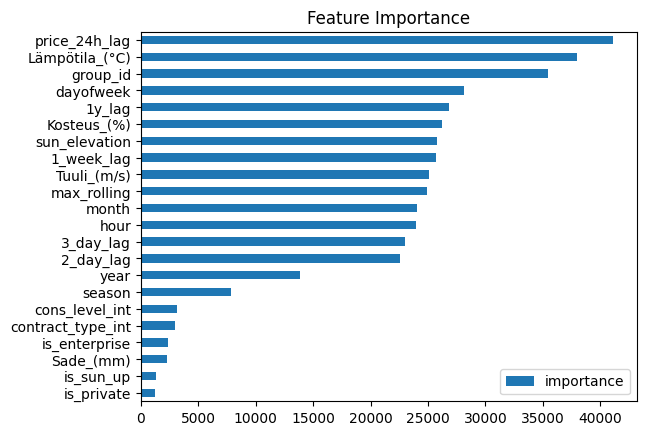

In [23]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test Set

In [24]:
# Make predictions for all 112 groups
test['prediction'] = reg.predict(X_test)

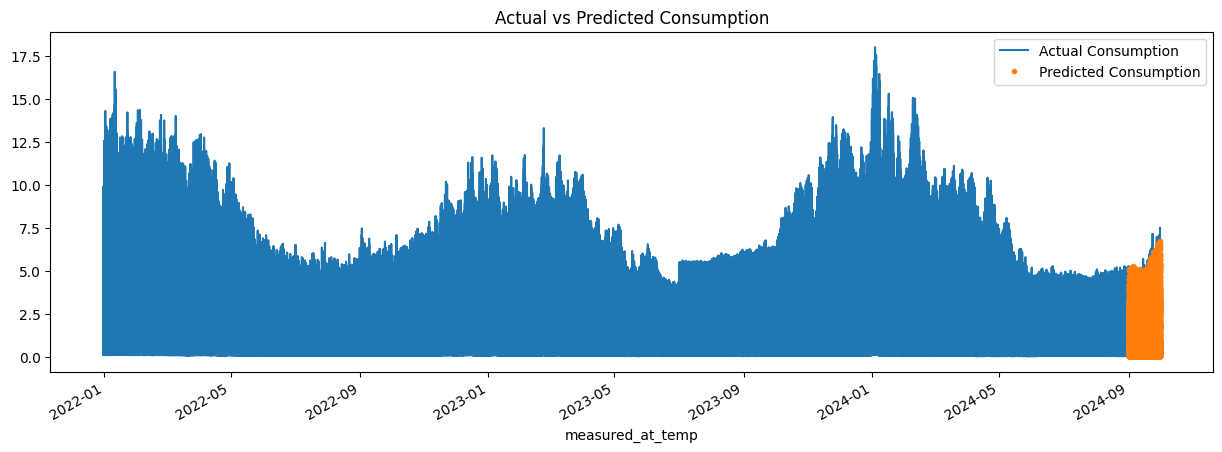

In [25]:
ax = df[['consumption']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Consumption', 'Predicted Consumption'])
ax.set_title('Actual vs Predicted Consumption')
plt.show()

# Metrics

In [26]:
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on test set: {mae:0.2f}")
print(f"MAPE on test set: {mape:0.2f}")
print(f"RMSE on test set: {rmse:0.2f}")

MAE on test set: 0.04
MAPE on test set: 0.05
RMSE on test set: 0.08


# Worst and best predicted days

In [27]:
test['error'] = np.abs(test['consumption'] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2024-09-22    0.071721
2024-09-23    0.063216
2024-09-14    0.051533
2024-09-21    0.050272
2024-09-15    0.048125
Name: error, dtype: float64

In [28]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2024-09-06    0.023392
2024-09-11    0.023933
2024-09-07    0.025693
2024-09-09    0.025716
2024-09-05    0.025976
Name: error, dtype: float64

# 48 Hour forecast
1. train the final model using all available data 
2. Create the final forecasting dataframe and add features onto it.
    - Weather features must be based on weather forecasts instead of actual values in the 48 hour forecast dataframe
3. Forecast and compare to the actual values in '/data/20251111_INTERNAL_actuals_hourly.csv'

In [29]:
#Actual values for consumption
actual_hourly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_hourly.csv"
actual_monthly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_monthly.csv"

actual_hourly_df = pd.read_csv(actual_hourly_path, sep=';', decimal=',')
actual_monthly_df = pd.read_csv(actual_monthly_path, sep=';', decimal=',')


# Train final model with the best parameters and all data 


In [30]:
features = ['group_id',
    'price_24h_lag', 'is_enterprise', 'is_private',
    'contract_type_int', 'cons_level_int',
    'hour', 'dayofweek', 'month', 'year', 'season',
    '2 day lag', '3 day lag', '1 week lag', '1y lag',
    'max_rolling',
    'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)', 
    'sun_elevation', 'is_sun_up'
]

X_final = df[features]
y_final = df['consumption']

final_model = lgb.LGBMRegressor(learning_rate=0.019603369861210685, num_leaves=122, max_depth=10, 
                            min_child_samples=54, subsample=0.7962072844310213, colsample_bytree=0.5232252063599989, 
                            lambda_l1=0.0029369981104377003, lambda_l2=3.425445902633376e-07,
                            n_estimators=4600, objective='regression', metric='mape', verbosity=-1)

final_model.fit(X_final, y_final,
                callbacks=[lgb.log_evaluation(period=100)])


,boosting_type,'gbdt'
,num_leaves,122
,max_depth,10
,learning_rate,0.019603369861210685
,n_estimators,4600
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,54


# Create the 48 hour forecasting dataframe and add features

In [31]:
#48 hour dataframe
dates_df = pd.DataFrame({'measured_at': pd.date_range('2024-10-01T00:00:00.000Z', '2024-10-02T23:00:00.000Z', freq='1h')})
df_groups = pd.DataFrame({'group_id': df['group_id'].unique()})

# 2. Perform a Cross Join (Cartesian Product)
hourly_df = dates_df.merge(df_groups, how='cross')

# 3. Set Index and Fix Types
hourly_df = hourly_df.set_index('measured_at')
hourly_df['group_id'] = hourly_df['group_id'].astype(df['group_id'].dtype)

# 4. Add flags
hourly_df['future_consumption'] = True
df['future_consumption'] = False
df_and_hourly = pd.concat([df, hourly_df])

df_and_hourly = create_ts_features(df_and_hourly)
df_and_hourly = add_lag(df_and_hourly)
df_and_hourly = add_stats(df_and_hourly)
df_and_hourly = add_group_features(df_and_hourly, groups_df)

In [32]:
# Load weather forecasting data and extract Oct 1-2, 2024 for forecast period
weather_df_full = pd.read_csv("forecast_saa_data_FINAL.csv")

weather_df_full = weather_df_full.rename(columns={'date': 'measured_at'})

weather_df_full['measured_at'] = pd.to_datetime(weather_df_full['measured_at'], utc=True)

# Filter for Oct 1-2, 2024
weather_oct = weather_df_full[
    (weather_df_full['measured_at'] >= '2024-10-01') & 
    (weather_df_full['measured_at'] <= '2024-10-02 23:59:59')
].copy()

print(f"Weather data for Oct 1-2, 2024: {len(weather_oct)} rows")
print(f"Date range: {weather_oct['measured_at'].min()} to {weather_oct['measured_at'].max()}")

weather_cols = ['measured_at', 'Kaupunki', 'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)']
weather_oct_clean = weather_oct[weather_cols].drop_duplicates(subset=['measured_at', 'Kaupunki'], keep='first')

forecast_for_merge = df_and_hourly.reset_index()

if 'measured_at' not in forecast_for_merge.columns and 'index' in forecast_for_merge.columns:
    forecast_for_merge = forecast_for_merge.rename(columns={'index': 'measured_at'})
    
forecast_for_merge['group_id_str'] = forecast_for_merge['group_id'].astype(str)
forecast_for_merge['Kaupunki'] = forecast_for_merge['group_id_str'].map(id_to_city_map)

forecast_for_merge = pd.merge(
    forecast_for_merge,
    weather_oct_clean,
    on=['measured_at', 'Kaupunki'],
    how='left',
    suffixes=('_old', '')
)

forecast_df_final = forecast_for_merge.set_index('measured_at')

print(f"\nWeather columns NaN count after merge:")
print(f"  Lämpötila: {forecast_df_final['Lämpötila (°C)'].isna().sum()}")
print(f"  Kosteus: {forecast_df_final['Kosteus (%)'].isna().sum()}")
print(f"  Sade: {forecast_df_final['Sade (mm)'].isna().sum()}")
print(f"  Tuuli: {forecast_df_final['Tuuli (m/s)'].isna().sum()}")

del df_and_hourly, forecast_for_merge, weather_oct, weather_df_full
gc.collect()


Weather data for Oct 1-2, 2024: 1200 rows
Date range: 2024-10-01 00:00:00+00:00 to 2024-10-02 23:00:00+00:00

Weather columns NaN count after merge:
  Lämpötila: 2701440
  Kosteus: 2701440
  Sade: 2706816
  Tuuli: 2701440


9

In [33]:
forecast_df_final.head()

,group_id,consumption,price_24h_lag,hour,dayofweek,month,year,season,2 day lag,3 day lag,...,is_private,is_enterprise,contract_type_int,cons_level_int,group_id_str,Kaupunki,Lämpötila (°C),Kosteus (%),Sade (mm),Tuuli (m/s)
measured_at,,,,,,,,,,,,,,,,,,,,,
2021-12-31 00:00:00+00:00,28,8.702998,30.04,0,4,12,2021,1,NaN,NaN,...,1,0,1,3,28,Savonlinna,NaN,NaN,NaN,NaN
2021-12-31 00:00:00+00:00,29,0.160143,26.15,0,4,12,2021,1,NaN,NaN,...,1,0,1,1,29,Savonlinna,NaN,NaN,NaN,NaN
2021-12-31 00:00:00+00:00,30,1.321842,30.04,0,4,12,2021,1,NaN,NaN,...,1,0,1,2,30,Savonlinna,NaN,NaN,NaN,NaN
2021-12-31 00:00:00+00:00,36,0.595434,26.15,0,4,12,2021,1,NaN,NaN,...,0,1,3,1,36,Joensuu,NaN,NaN,NaN,NaN
2021-12-31 00:00:00+00:00,37,0.166907,30.04,0,4,12,2021,1,NaN,NaN,...,1,0,2,1,37,Joensuu,NaN,NaN,NaN,NaN


In [34]:

if 'static_cols' not in locals():
    static_cols = ['is_enterprise', 'is_private', 'contract_type_int', 'cons_level_int']

if forecast_df_final.index.name != 'measured_at':
    if 'measured_at' in forecast_df_final.columns:
        forecast_df_final = forecast_df_final.set_index('measured_at')
    forecast_df_final.index.name = 'measured_at'

forecast_df_final = forecast_df_final.sort_index()
cols_to_drop = ['sun_elevation', 'is_sun_up', 'latitude', 'longitude', 'temp_coords', 'group_id_str']
existing_cols = [c for c in cols_to_drop if c in forecast_df_final.columns]
if existing_cols:
    forecast_df_final = forecast_df_final.drop(columns=existing_cols)

forecast_df_final['group_id_str'] = forecast_df_final['group_id'].astype(str)
forecast_df_final['temp_coords'] = forecast_df_final['group_id_str'].map(id_to_coords)
south_coords = zone_coords['South']
forecast_df_final['temp_coords'] = forecast_df_final['temp_coords'].apply(
    lambda x: x if isinstance(x, tuple) else south_coords
)

coords_temp = pd.DataFrame(forecast_df_final['temp_coords'].tolist(), index=forecast_df_final.index)
forecast_df_final['latitude'] = coords_temp[0]
forecast_df_final['longitude'] = coords_temp[1]

unique_sun_params = forecast_df_final.reset_index()[['measured_at', 'latitude', 'longitude']].drop_duplicates()

def calculate_sun_fast(row):
    try:
        obs = Observer(latitude=row['latitude'], longitude=row['longitude'])
        return elevation(obs, row['measured_at'])
    except:
        return 0.0

unique_sun_params['sun_elevation'] = unique_sun_params.apply(calculate_sun_fast, axis=1)

forecast_df_final = forecast_df_final.reset_index().merge(
    unique_sun_params,
    on=['measured_at', 'latitude', 'longitude'],
    how='left'
).set_index('measured_at')

forecast_df_final['is_sun_up'] = (forecast_df_final['sun_elevation'] > 0).astype(int)

forecast_df_final.drop(columns=['latitude', 'longitude', 'temp_coords', 'group_id_str'], inplace=True)

if 'price_24h_lag' in forecast_df_final.columns:
    forecast_df_final = forecast_df_final.drop(columns=['price_24h_lag'])

price_col_name = 'price_24h_lag'

hist_prices = df[[price_col_name]].copy()

hist_prices.index.name = 'measured_at'

hist_prices = hist_prices.reset_index()
hist_prices = hist_prices.rename(columns={price_col_name: 'price'})

new_prices = prices_df[['measured_at', 'eur_per_mwh']].copy()
new_prices = new_prices.rename(columns={'eur_per_mwh': 'price'})

hist_prices['measured_at'] = pd.to_datetime(hist_prices['measured_at'], utc=True)
new_prices['measured_at'] = pd.to_datetime(new_prices['measured_at'], utc=True)

full_price_history = pd.concat([hist_prices, new_prices]).drop_duplicates(subset=['measured_at']).set_index('measured_at').sort_index()

forecast_df_final['lookback_time'] = forecast_df_final.index - pd.Timedelta(hours=24)

price_dict = full_price_history['price'].to_dict()
forecast_df_final['price_24h_lag'] = forecast_df_final['lookback_time'].map(price_dict)

forecast_df_final.drop(columns=['lookback_time'], inplace=True)

check_cols = ['sun_elevation', 'is_sun_up', 'price_24h_lag']
for col in static_cols:
    if col in forecast_df_final.columns:
        check_cols.append(col)

print("\nNaN-arvojen määrä featureissa:")
print(forecast_df_final[check_cols].isna().sum())

print("\nValmis! Featuret lisätty ja KeyErr korjattu.")


NaN-arvojen määrä featureissa:
sun_elevation        0
is_sun_up            0
price_24h_lag        0
is_enterprise        0
is_private           0
contract_type_int    0
cons_level_int       0
dtype: int64

Valmis! Featuret lisätty ja KeyErr korjattu.


In [ ]:
forecast_df_final.tail()

,group_id,consumption,hour,dayofweek,month,year,season,2 day lag,3 day lag,1 week lag,...,contract_type_int,cons_level_int,Kaupunki,Lämpötila (°C),Kosteus (%),Sade (mm),Tuuli (m/s),sun_elevation,is_sun_up,price_24h_lag
measured_at,,,,,,,,,,,,,,,,,,,,,
2024-10-02 23:00:00+00:00,708,NaN,23,2,10,2024,4,0.419994,0.392745,0.363310,...,1,2,Tampere,4.5125,97.0,NaN,6.830519,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,709,NaN,23,2,10,2024,4,0.093738,0.098404,0.098257,...,3,1,Tampere,4.5125,97.0,NaN,6.830519,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,738,NaN,23,2,10,2024,4,0.607188,0.606414,0.475525,...,1,2,Seinäjoki,2.7710,95.0,NaN,6.287130,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,740,NaN,23,2,10,2024,4,0.068655,0.067881,0.068872,...,3,1,Seinäjoki,2.7710,95.0,NaN,6.287130,-30.94573,0,99.86
2024-10-02 23:00:00+00:00,741,NaN,23,2,10,2024,4,0.441714,0.483278,0.378755,...,3,2,Seinäjoki,2.7710,95.0,NaN,6.287130,-30.94573,0,99.86


In [36]:

future_mask = forecast_df_final['future_consumption'] == True
X_future = forecast_df_final.loc[future_mask, features].copy()



predictions = final_model.predict(X_future)

forecast_df_final['prediction'] = np.nan
forecast_df_final.loc[future_mask, 'prediction'] = predictions
forecast_df_final.loc[future_mask, 'prediction'] = forecast_df_final.loc[future_mask, 'prediction'].clip(lower=0)

submission_data = forecast_df_final.loc[future_mask, ['group_id', 'prediction']]

submission_wide = submission_data.pivot(columns='group_id', values='prediction')

submission_wide.columns.name = None


submission_wide.to_csv("48_hour_forecast.csv", index=True)

print(submission_wide.head())

                                 28        29        30        36        37  \
measured_at                                                                   
2024-10-01 00:00:00+00:00  4.572156  0.114691  0.619713  0.308153  0.114090   
2024-10-01 01:00:00+00:00  4.673842  0.114681  0.627325  0.308486  0.115143   
2024-10-01 02:00:00+00:00  4.555648  0.116977  0.651960  0.312089  0.122888   
2024-10-01 03:00:00+00:00  4.648773  0.128729  0.675231  0.330557  0.141624   
2024-10-01 04:00:00+00:00  4.605845  0.144330  0.709945  0.350795  0.166822   

                                 38        39        40        41        42  \
measured_at                                                                   
2024-10-01 00:00:00+00:00  0.428620  0.116772  0.117392  0.494170  0.108102   
2024-10-01 01:00:00+00:00  0.430653  0.116735  0.117078  0.476554  0.109696   
2024-10-01 02:00:00+00:00  0.435862  0.119100  0.119411  0.494141  0.113212   
2024-10-01 03:00:00+00:00  0.498322  0.138065  0.13

# MAPE of the final forecast

In [37]:
actual_hourly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_hourly.csv"
actuals_df = pd.read_csv(actual_hourly_path, sep=';', decimal=',')
forecast_df = pd.read_csv("48_hour_forecast.csv")

cols_value = actuals_df.columns.drop('measured_at')
for col in cols_value:
    actuals_df[col] = actuals_df[col].astype(str).str.replace(',', '.').astype(float)

forecast_df['measured_at'] = pd.to_datetime(forecast_df['measured_at'])
actuals_df['measured_at'] = pd.to_datetime(actuals_df['measured_at'])

forecast_df.set_index('measured_at', inplace=True)
actuals_df.set_index('measured_at', inplace=True)

common_index = forecast_df.index.intersection(actuals_df.index)
common_cols = forecast_df.columns.intersection(actuals_df.columns)

forecast_aligned = forecast_df.loc[common_index, common_cols]
actuals_aligned = actuals_df.loc[common_index, common_cols]

mask = actuals_aligned != 0
mape = np.mean(np.abs((actuals_aligned[mask] - forecast_aligned[mask]) / actuals_aligned[mask]))

print(f"Overall MAPE: {mape.mean():.4f}")

Overall MAPE: 0.0644


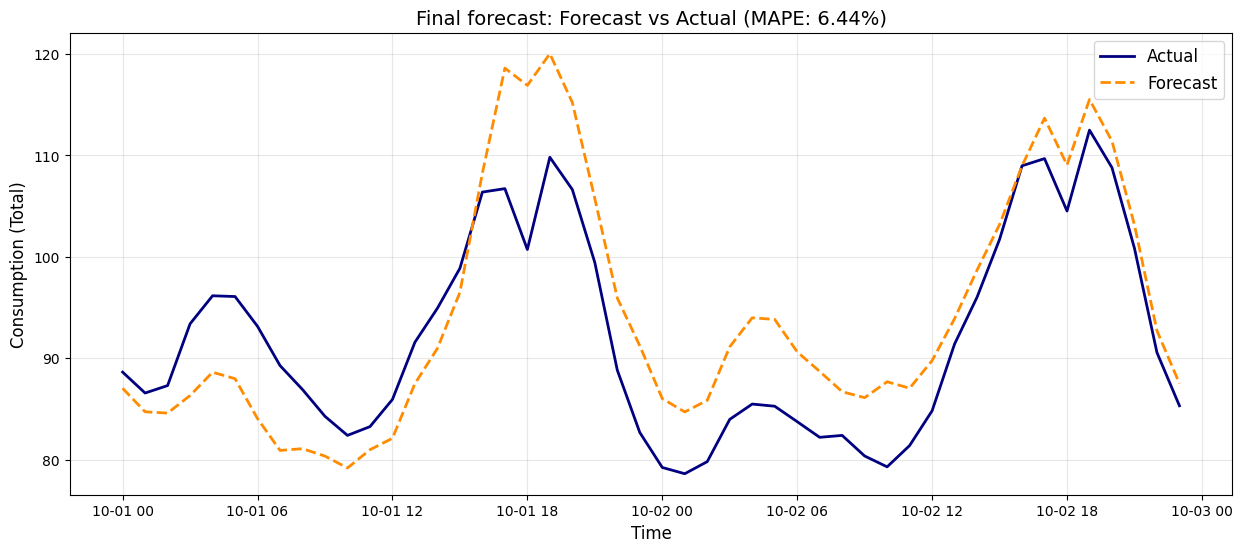

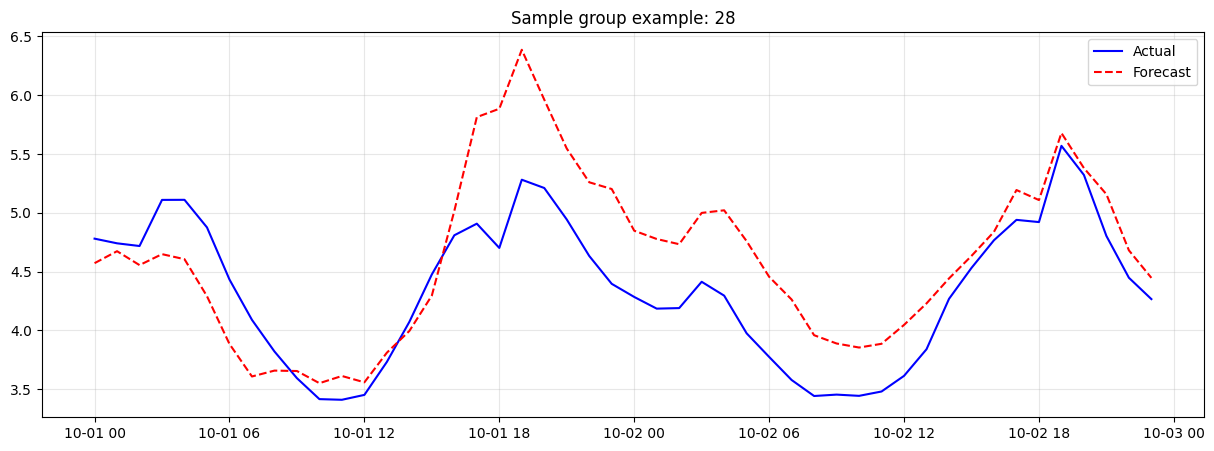

In [38]:
import matplotlib.pyplot as plt

#Total sum of consumption across all groups
total_actual = actuals_aligned.sum(axis=1)
total_forecast = forecast_aligned.sum(axis=1)

plt.figure(figsize=(15, 6))

plt.plot(total_actual.index, total_actual, label='Actual', color='navy', linewidth=2)
plt.plot(total_forecast.index, total_forecast, label='Forecast', color='darkorange', linestyle='--', linewidth=2)

plt.title(f'Final forecast: Forecast vs Actual (MAPE: {mape.mean():.2%})', fontsize=14)
plt.ylabel('Consumption (Total)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

plt.figure(figsize=(15, 5))
sample_col = common_cols[0]
plt.plot(actuals_aligned.index, actuals_aligned[sample_col], label='Actual', color='blue')
plt.plot(forecast_aligned.index, forecast_aligned[sample_col], label='Forecast', color='red', linestyle='--')
plt.title(f'Sample group example: {sample_col}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()